# Dense Retrieval Passage for Open Domain Question & Answering
Submitted by: Rishabh Kaushick
<br>Date: March 16, 2025

# 1. Environment Setup

In [1]:
%pip install --quiet torch transformers faiss-cpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
# installing datasets (hugging face dataset library)
%pip install --quiet datasets

Note: you may need to restart the kernel to use updated packages.


Restarting the kernel as suggested.

In [3]:
%reset

In [4]:
import torch
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt

/opt/homebrew/anaconda3/envs/csye7230/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CUDA: GPU Availability

In [5]:
 
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.6.0
Is CUDA available: False
CUDA is not available. Running on CPU.


# 2. Dataset Selection and Exploration (15%)

## Loading Dataset (from HuggingFace)

### Download Training Set

In [5]:
dataset = load_dataset("ms_marco", "v2.1", split="train[:15000]")

Generating test split: 100%|██████████| 101092/101092 [00:00<00:00, 309588.97 examples/s]


### Saving Training Set to Disk

In [ ]:
# need to save the dataset in /data/train
dataset.save_to_disk("./data/train/ms_marco_15k")

### Loading Train Set from Disk

In [6]:
# https://huggingface.co/docs/datasets/v3.3.2/en/package_reference/main_classes#datasets.Dataset.save_to_disk

# load the already saved dataset from the disk
dataset = load_from_disk("./data/train/ms_marco_15k")

In [7]:
print(len(dataset))

15000


### Loading & Saving Validation Set

In [8]:
validation_dataset = load_dataset("ms_marco", "v2.1", split="validation[:10000]")

In [9]:
# save validation dataset
validation_dataset.save_to_disk("./data/validation/ms_marco")

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 103656.22 examples/s]


In [7]:
validation_dataset = load_from_disk("./data/validation/ms_marco")

In [9]:
len(validation_dataset)

10000

### Loading & Saving Test Set

In [12]:
test_dataset = load_dataset("ms_marco", "v2.1", split="test[:10000]")

In [13]:
# save test dataset to the disk
test_dataset.save_to_disk("./data/test/ms_marco")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 97400.38 examples/s]


In [8]:
test_dataset = load_from_disk("./data/test/ms_marco")

## Exploratory Data Analysis

In [10]:
dataset

Dataset({
    features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
    num_rows: 15000
})

In [11]:
type(dataset)

datasets.arrow_dataset.Dataset

Since the above is a different datatype for the dataset, for convenience, I am converting this to pandas DataFrame.

In [12]:
train_df = dataset.data.to_pandas()
train_df.head()

,answers,passages,query,query_id,query_type,wellFormedAnswers
0,[The immediate impact of the success of the ma...,"{'is_selected': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",)what was the immediate impact of the success ...,1185869,DESCRIPTION,[]
1,[Restorative justice that fosters dialogue bet...,"{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]...",_________ justice is designed to repair the ha...,1185868,DESCRIPTION,[]
2,[The reasons why Stalin wanted to control East...,"{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]...",why did stalin want control of eastern europe,1185854,DESCRIPTION,[]
3,[Nails rust in water because water allows the ...,"{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]...",why do nails get rusty,1185755,DESCRIPTION,[]
4,"[Depona Ab is a library in Vilhelmina, Sweden.]","{'is_selected': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]...",depona ab,1184773,DESCRIPTION,[]


### Query & Answers (Examples)

In [13]:
train_df[['query', 'answers']].tail()

,query,answers
14995,what is a traditional breakfast food in chile,[Fresh bread (pan amasado) with fruit jellies ...
14996,what are the colors of a croton flower,"[Originally croton leaves are green, but it ch..."
14997,what is ce with a medical device,[CE Marking is a mandatory requirement for med...
14998,were ancient iberians an ethnic group?,[The Iberians were not a ethnic group.]
14999,what is a nanofiller,[No Answer Present.]


### Data & Data types

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   answers            15000 non-null  object
 1   passages           15000 non-null  object
 2   query              15000 non-null  object
 3   query_id           15000 non-null  int32 
 4   query_type         15000 non-null  object
 5   wellFormedAnswers  15000 non-null  object
dtypes: int32(1), object(5)
memory usage: 644.7+ KB


#### Query ID 

In [15]:
train_df['query_id'].nunique()

15000

In [16]:
train_df.describe()

,query_id
count,1.500000e+04
mean,5.317663e+05
std,2.870053e+05
min,9.900000e+01
25%,3.797632e+05
50%,5.198510e+05
75%,6.633990e+05
max,1.185869e+06


Based on the statistical distribution above the Query ID column has values ranging from 99 to ~1.2 million. Therefore int32 is the smallest and most optimal datatype for this column. 


#### Query Type

In [17]:
train_df['query_type'].unique()

array(['DESCRIPTION', 'LOCATION', 'NUMERIC', 'ENTITY', 'PERSON'],
      dtype=object)

In [18]:
query_type_counts = train_df['query_type'].value_counts()
query_type_counts

query_type
DESCRIPTION    9344
NUMERIC        3232
ENTITY         1392
LOCATION        632
PERSON          400
Name: count, dtype: int64

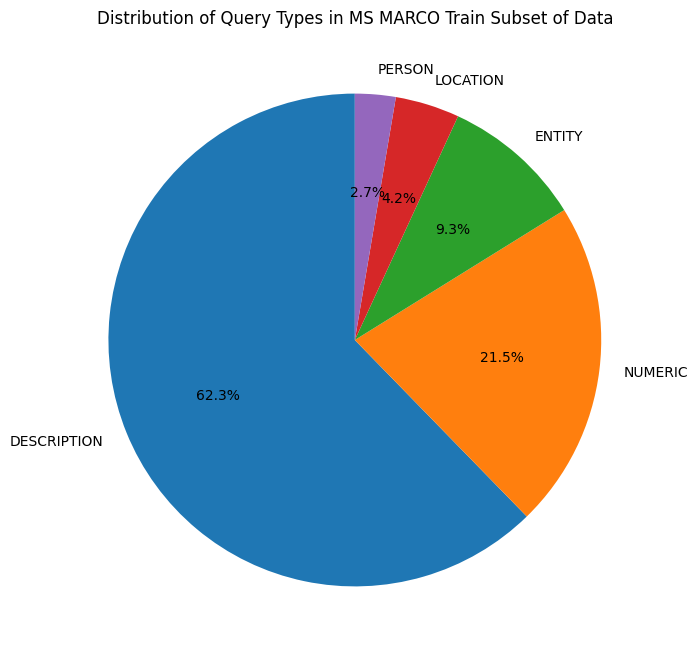

In [19]:
# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(query_type_counts.values, 
        labels=query_type_counts.index, 
        autopct='%1.1f%%', 
        startangle=90)

plt.title('Distribution of Query Types in MS MARCO Train Subset of Data')

plt.show()

Let's look at different query types:

In [20]:
# query type: DESCRIPTION
train_df.query("query_type == 'DESCRIPTION'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
0,)what was the immediate impact of the success ...,[The immediate impact of the success of the ma...,[]
1,_________ justice is designed to repair the ha...,[Restorative justice that fosters dialogue bet...,[]
2,why did stalin want control of eastern europe,[The reasons why Stalin wanted to control East...,[]
3,why do nails get rusty,[Nails rust in water because water allows the ...,[]
4,depona ab,"[Depona Ab is a library in Vilhelmina, Sweden.]",[]
...,...,...,...
14992,minimalism meaning,[Minimalism is a movement in sculpture and pai...,[]
14994,what does motd stand for in terraria,[No Answer Present.],[]
14997,what is ce with a medical device,[CE Marking is a mandatory requirement for med...,[]
14998,were ancient iberians an ethnic group?,[The Iberians were not a ethnic group.],[]


In [21]:
# query type: LOCATION
train_df.query("query_type == 'LOCATION'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
5,is the atlanta airport the busiest in the world,[No Answer Present.],[]
18,what county is dewitt michigan in?,"[DeWitt is located in Clinton County, Michigan...",[]
23,what county is columbus city in,[Bartholomew],[Columbus is a city in Bartholomew County.]
26,"what county is shelton, ct","[Shelton is in Fairfield County, Connecticut, ...",[]
42,what county is seminole fl in,[Pinellas County],"[Seminole, Florida is in Pinellas County.]"
...,...,...,...
14872,is dubai a world city,[Yes],[]
14945,"what county is hazelwood, pa located",[Allegheny County],[]
14947,what county is louin ms in,[Jasper County],"[Louin is located in Jasper County, Mississippi.]"
14959,mindbodygreen address,[No Answer Present.],[]


In [22]:
# query type: NUMERIC
train_df.query("query_type == 'NUMERIC'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
6,nyu tuition cost,"[$43,746 for the 2014-2015 academic year.]",[]
7,at what age do kids start to hold memories,[Before the age of 2–4 years.],[]
8,average teeth brushing time,[Americans brush for just under the two minute...,[]
12,artin chicken mcdonalds calories,[No Answer Present.],[]
15,sum of squares of even numbers formula,[No Answer Present.],[]
...,...,...,...
14971,what % of your body weight should be water,[The amount of water in the human body ranges ...,[]
14972,how much caffeine is in green coffee,[20 mg],[There is 20 mg of caffeine in green coffee.]
14975,how far is secrets punta cana from the airport,[No Answer Present.],[]
14986,planting distance for blue plumbago,[36 to 60 inches apart],[The planting distance for blue plumbago 36 to...


In [23]:
# query type: ENTITY
train_df.query("query_type == 'ENTITY'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
21,what is early bird check in southwest,[It allows passengers to check-in to a flight ...,[]
46,what is home food store,[No Answer Present.],[]
60,is the cheetah an endangered species,"[Yes, Cheetah is considered Endangered species.]",[]
69,Niegerian Prophet turns into a snake in church...,[No Answer Present.],[]
72,what are signs of ulcers in equine,[No Answer Present.],[]
...,...,...,...
14952,what dog breed is kevin in the movie the proposal,[No Answer Present.],[]
14955,hay fever mouth,[The symptoms of hay fever include frequent sn...,[]
14958,international home foods inc,"[It was an American manufacturer, distributor ...",[]
14995,what is a traditional breakfast food in chile,[Fresh bread (pan amasado) with fruit jellies ...,[]


In [24]:
# query type: PERSON
train_df.query("query_type == 'PERSON'")[['query', 'answers', 'wellFormedAnswers']]

,query,answers,wellFormedAnswers
56,was the president of morehouse college recentl...,[No Answer Present.],[]
106,most romantic hotels in bahamas,[No Answer Present.],[]
139,the place beyond the pines cast,[It is actually the Native American meaning to...,[]
141,largest active military,[China],[China has the largest active military.]
346,the incredible hulk. actor,[Yes],[]
...,...,...,...
14798,cast of haven season 5 episode 8,[No Answer Present.],[]
14819,longest man space flight,[Valeri Polyakov],[Valeri Polyakov has been longest man in space...
14867,what channel is nfl network,[An American sports-oriented cable.],[]
14890,what committees is kathy lohmer on,[Health and Human Services Policy Health and H...,[]


#### Passages

In [25]:
train_df['passages'][0]

{'is_selected': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'passage_text': array(['The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.',
        'The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and science.',
        'Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it known that something this powerful can be manmade.',
        'The Manhattan Project was the name for a project conducted during World War II, to develop the first atomic bomb. It refe

In [26]:
train_df['passages'][0]['passage_text']

array(['The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.',
       'The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and science.',
       'Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it known that something this powerful can be manmade.',
       'The Manhattan Project was the name for a project conducted during World War II, to develop the first atomic bomb. It refers specifically to the period of the project from 194 … 2-1946 under the control of the 

### Missing Data
Based on the above exploration of the dataset, we can see that some of the queries don't have answers. Let's see how many don't have an answer.

In [27]:
type(train_df['answers'])

pandas.core.series.Series

In [28]:
type(train_df['answers'][0])

numpy.ndarray

In [29]:
train_df['answers'][0]

array(['The immediate impact of the success of the manhattan project was the only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.'],
      dtype=object)

In [30]:
train_df['answers'][0][0]

'The immediate impact of the success of the manhattan project was the only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.'

In [31]:
train_df['answers'][14999]

array(['No Answer Present.'], dtype=object)

In [32]:
no_answer_records = train_df.query("answers in 'No Answer Present.'")
no_answer_records[:5]

,answers,passages,query,query_id,query_type,wellFormedAnswers
5,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",is the atlanta airport the busiest in the world,1174762,LOCATION,[]
10,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",what direction does phloem flow,620830,DESCRIPTION,[]
12,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",artin chicken mcdonalds calories,27022,NUMERIC,[]
13,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",is panglao island safe,420332,DESCRIPTION,[]
14,[No Answer Present.],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...",what is calomel powder used for?,727194,DESCRIPTION,[]


In [33]:
len(no_answer_records)

5853

There are a total of 5 thousand for which the answer is not present. This is about one third of the entire training data. In case the model is not able to answer questions, we can consider retraining it with more data from the MS Marco dataset.

## Preprocess Data

In [34]:
from transformers import AutoTokenizer

In [35]:
# converting the passage from the dictionary to a string value
train_df['passage_text'] = train_df['passages'].apply(lambda x: x['passage_text'])

# Make sure all elements are strings
train_df['passage_text'] = [str(text) for text in train_df['passage_text']]

In [37]:
# using the DistilBERT model so that we can fine tune the retrieval component
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


# tokenizing the passages from the 'passage' column for the 'passage_text' key 
tokenized_passages = tokenizer(train_df['passage_text'].to_list(),
                                max_length=128, 
                                truncation=True, 
                                padding=True,
                                return_tensors="pt"
                                )

In [38]:
tokenized_passages

{'input_ids': tensor([[ 101, 1031, 1005,  ..., 2088, 5091,  102],
        [ 101, 1031, 1005,  ..., 2008, 2421,  102],
        [ 101, 1031, 1005,  ..., 2981, 1999,  102],
        ...,
        [ 101, 1031, 1005,  ..., 1006, 2006,  102],
        [ 101, 1031, 1005,  ..., 2171, 1999,  102],
        [ 101, 1031, 1005,  ..., 2024, 4321,  102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [42]:
train_df[['query', 'answers']].head(5)

,query,answers
0,)what was the immediate impact of the success ...,[The immediate impact of the success of the ma...
1,_________ justice is designed to repair the ha...,[Restorative justice that fosters dialogue bet...
2,why did stalin want control of eastern europe,[The reasons why Stalin wanted to control East...
3,why do nails get rusty,[Nails rust in water because water allows the ...
4,depona ab,"[Depona Ab is a library in Vilhelmina, Sweden.]"
